In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


Ankle Boot  T-shirt/top  Coat  Coat


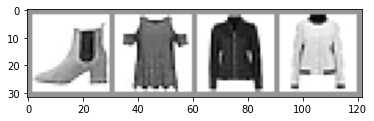

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [80]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import orthogonal

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = orthogonal(nn.Linear(10,10, dtype=torch.cfloat))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [81]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.9392, 0.6962, 0.8568, 0.6395, 0.9127, 0.3396, 0.1583, 0.2288, 0.4228,
         0.0489],
        [0.2102, 0.3838, 0.4192, 0.2881, 0.8776, 0.3203, 0.0988, 0.5116, 0.7079,
         0.3995],
        [0.2191, 0.9446, 0.9149, 0.0649, 0.6703, 0.5750, 0.9754, 0.0385, 0.0947,
         0.2632],
        [0.8200, 0.2511, 0.6460, 0.2973, 0.1401, 0.1723, 0.4637, 0.8902, 0.8790,
         0.2816]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.331254720687866


In [82]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [83]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [84]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.6806668536812066
  batch 2000 loss: 0.8273845522720367
  batch 3000 loss: 0.6791668776478619
  batch 4000 loss: 0.6176750096506439
  batch 5000 loss: 0.6179355203490704
  batch 6000 loss: 0.5460427628748584
  batch 7000 loss: 0.5196379040140892
  batch 8000 loss: 0.5030153584796936
  batch 9000 loss: 0.4932342100144015
  batch 10000 loss: 0.47388212477834896
  batch 11000 loss: 0.46093765488266947
  batch 12000 loss: 0.4346990059631062
  batch 13000 loss: 0.43531280183733906
  batch 14000 loss: 0.4270411509666592
  batch 15000 loss: 0.4312904790651519


KeyboardInterrupt: 

In [87]:
for layer in model.named_parameters():
    print(layer)

('conv1.weight', Parameter containing:
tensor([[[[-0.1093, -0.3171, -0.3943, -0.3184, -0.2577],
          [ 0.0076, -0.1184, -0.3599, -0.4771, -0.2750],
          [ 0.1886,  0.0881, -0.1252, -0.2308, -0.0442],
          [ 0.1691,  0.1386,  0.1533,  0.0881,  0.2115],
          [ 0.1532, -0.0469, -0.0805,  0.0945,  0.0597]]],


        [[[-0.0746, -0.1390,  0.0094, -0.3348, -0.1648],
          [ 0.0068, -0.1851, -0.0846, -0.2756, -0.0712],
          [-0.1325,  0.0941, -0.0090,  0.1103,  0.1251],
          [ 0.1739,  0.1540,  0.0952,  0.2769, -0.2566],
          [ 0.1633,  0.4004,  0.2180,  0.2609, -0.3142]]],


        [[[-0.0277, -0.0171, -0.1490, -0.1711, -0.0455],
          [ 0.1902,  0.0845, -0.1242, -0.2292, -0.1663],
          [ 0.0036, -0.0539, -0.1620,  0.0131,  0.1351],
          [-0.2558, -0.3964, -0.3812, -0.1733,  0.1304],
          [-0.2008, -0.3143, -0.2151, -0.2177,  0.0506]]],


        [[[ 0.2211,  0.2519,  0.0181, -0.6498, -0.2602],
          [ 0.2079,  0.3253,  0.0387,

In [45]:
Q = model.state_dict()['fc4.parametrizations.weight.original']
print(torch.dist(Q.T @ Q, torch.eye(10)))
print(Q)

tensor(0.)
tensor([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])


In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

batch_size = 64
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = datasets.MNIST('../data', train=True, transform=trans, download=True)
test_set = datasets.MNIST('../data', train=False, transform=trans, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle=True)

In [73]:
class ComplexNet(nn.Module):
    
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 5, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 5, 1)
        self.fc1 = ComplexLinear(4*4*20, 500)
        self.fc2 = ComplexLinear(500, 10)
        self.fc3 = orthogonal(ComplexLinear(10,10))
             
    def forward(self,x):
        x = self.conv1(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        x = x.abs()
        x =  F.log_softmax(x, dim=1)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ComplexNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

ValueError: Module 'ComplexLinear(
  (fc_r): Linear(in_features=10, out_features=10, bias=True)
  (fc_i): Linear(in_features=10, out_features=10, bias=True)
)' has no parameter ot buffer with name 'weight'

In [65]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).type(torch.complex64), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item())
            )

In [66]:
# Run training on 50 epochs
for epoch in range(1):
    train(model, device, train_loader, optimizer, epoch)

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 2.474864
Train Epoch:   0 [  6400/ 60000 ( 11%)]	Loss: 0.119842
Train Epoch:   0 [ 12800/ 60000 ( 21%)]	Loss: 0.137026
Train Epoch:   0 [ 19200/ 60000 ( 32%)]	Loss: 0.048653
Train Epoch:   0 [ 25600/ 60000 ( 43%)]	Loss: 0.060973
Train Epoch:   0 [ 32000/ 60000 ( 53%)]	Loss: 0.150029
Train Epoch:   0 [ 38400/ 60000 ( 64%)]	Loss: 0.041426
Train Epoch:   0 [ 44800/ 60000 ( 75%)]	Loss: 0.038588
Train Epoch:   0 [ 51200/ 60000 ( 85%)]	Loss: 0.068409
Train Epoch:   0 [ 57600/ 60000 ( 96%)]	Loss: 0.028518


In [70]:
for layer in model.named_parameters():
    print(layer)

('conv1.conv_r.weight', Parameter containing:
tensor([[[[ 0.0004,  0.0729, -0.0415, -0.1739,  0.0597],
          [ 0.0036, -0.1216, -0.2125, -0.0172, -0.2331],
          [ 0.2563,  0.1374,  0.1149, -0.0437, -0.1041],
          [-0.0212,  0.1087,  0.1733,  0.1807, -0.1437],
          [-0.1079, -0.1205,  0.1751,  0.1483,  0.0077]]],


        [[[ 0.2020, -0.0469,  0.1907,  0.2836, -0.0289],
          [ 0.1146, -0.1203, -0.0564,  0.1274,  0.1214],
          [-0.0680, -0.1652, -0.2407, -0.0627, -0.0725],
          [-0.1568, -0.2206, -0.0737, -0.1829,  0.1660],
          [-0.1273,  0.1912, -0.0734,  0.0870, -0.0808]]],


        [[[ 0.0661, -0.1141, -0.0722, -0.2033, -0.1182],
          [-0.0294, -0.0546, -0.1643,  0.1872,  0.0667],
          [ 0.1797,  0.1603,  0.2162,  0.1259,  0.1086],
          [ 0.0862,  0.1713,  0.1078, -0.1265,  0.1565],
          [-0.2527, -0.1983, -0.1668,  0.0207, -0.0845]]],


        [[[-0.0747, -0.0135,  0.0982, -0.0624,  0.1952],
          [-0.0744,  0.0510,  